**Part 1**

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# read all the words
words = open('names.txt', 'r').read().splitlines()

In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)

In [6]:
# build the dataset

block_size = 3 # context length : how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
#     print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
#         print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [7]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            indx = stoi[ch]
            X.append(context)
            Y.append(indx)
            context = context[1:] + [indx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
stepi = []
max_steps = 200000
# lrs = torch.arange(0.1, 0.01, )

for i in range(max_steps):

    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[indx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[indx])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 200000: 28.1340
  10000/ 200000: 2.3161
  20000/ 200000: 2.0925
  30000/ 200000: 2.5501
  40000/ 200000: 2.5017
  50000/ 200000: 1.9447
  60000/ 200000: 2.8620
  70000/ 200000: 2.2753
  80000/ 200000: 2.3566
  90000/ 200000: 2.5822
 100000/ 200000: 2.2971
 110000/ 200000: 1.7853
 120000/ 200000: 2.2113
 130000/ 200000: 2.4483
 140000/ 200000: 2.0281
 150000/ 200000: 1.8455
 160000/ 200000: 2.1713
 170000/ 200000: 2.1070
 180000/ 200000: 2.2589
 190000/ 200000: 2.3232


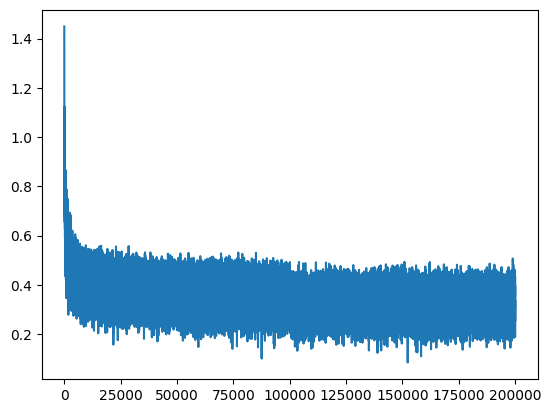

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1210, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1547, grad_fn=<NllLossBackward0>)

Observing that the initial loss is very high, I increased the learning rate for the initial iterations to not waste many iterations on reducing the initial loss. Also adjusted the epochs accordingly.

**Part 2**

In [ ]:
# Loss if predicted probabilities at initialization were perfectly uniform

In [ ]:
# In that case each probability would have been same which is 1/27

In [ ]:
probs = torch.ones(27)

In [ ]:
probs /= probs.sum()

In [ ]:
probs

tensor([0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370,
        0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370, 0.0370])

In [ ]:
log_likelihoods = probs.log()
log_likelihoods

tensor([-3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958,
        -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958,
        -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958, -3.2958,
        -3.2958, -3.2958, -3.2958])

In [ ]:
nll = -log_likelihoods.sum()
nll/27

tensor(3.2958)

Loss when the predicted probabilities were initialized uniformly is **3.2958**. But the loss we achieved actually in our method is **28.1340**

This high value is because of the randomness of the values in logits. We can reduce that by decreasing the value of b2 to 0 and W2 to values near to zero by scaling.

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)*0.01
b2 = torch.randn(27, generator=g)*0
parameters = [C, W1, b1, W2, b2]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
stepi = []
max_steps = 200000
# lrs = torch.arange(0.1, 0.01, )

for i in range(max_steps):

    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[indx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[indx])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3145
  10000/ 200000: 2.4188
  20000/ 200000: 2.2371
  30000/ 200000: 2.0043
  40000/ 200000: 2.2421
  50000/ 200000: 2.2412
  60000/ 200000: 2.1352
  70000/ 200000: 2.6034
  80000/ 200000: 2.3239
  90000/ 200000: 2.1492
 100000/ 200000: 2.3930
 110000/ 200000: 2.1711
 120000/ 200000: 2.4628
 130000/ 200000: 2.1156
 140000/ 200000: 2.2333
 150000/ 200000: 2.1752
 160000/ 200000: 1.9478
 170000/ 200000: 2.2484
 180000/ 200000: 2.3186
 190000/ 200000: 2.1979


Hurray! We have achieved the loss similar to the one we want

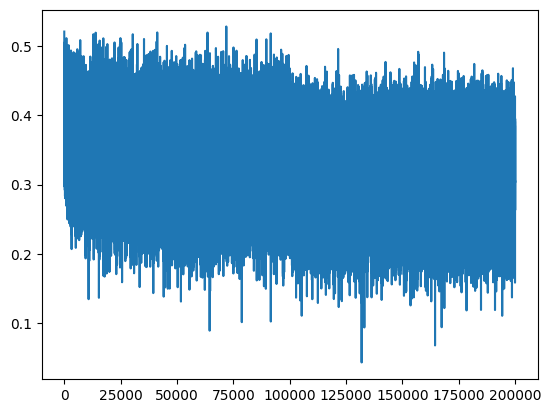

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0694, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1306, grad_fn=<NllLossBackward0>)

**Part 3**

In [ ]:
# One idea to implement from the paper is using non-linearity in hidden layer

In [ ]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 200), generator=g)
b2 = torch.randn(200, generator=g)
W3 = torch.randn((200, 27), generator=g)*0.01
b3 = torch.randn(27, generator=g)*0
parameters = [C, W1, b1, W2, b2, W3, b3]

In [ ]:
for p in parameters:
    p.requires_grad = True

In [ ]:
lossi = []
stepi = []
max_steps = 200000

for i in range(max_steps):

    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (32,))

    # forward pass
    emb = C[Xtr[indx]]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
    hidd = torch.tanh(h @ W2 + b2)
    logits = hidd @ W3 + b3
    loss = F.cross_entropy(logits, Ytr[indx])

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    stepi.append(i)
    lossi.append(loss.log10().item())

      0/ 200000: 3.3059
  10000/ 200000: 2.3162
  20000/ 200000: 2.4482
  30000/ 200000: 2.4013
  40000/ 200000: 1.8527
  50000/ 200000: 2.4278
  60000/ 200000: 2.3712
  70000/ 200000: 2.1137
  80000/ 200000: 2.1700
  90000/ 200000: 2.2800
 100000/ 200000: 2.4854
 110000/ 200000: 2.3244
 120000/ 200000: 2.5431
 130000/ 200000: 2.2414
 140000/ 200000: 2.3956
 150000/ 200000: 1.8802
 160000/ 200000: 2.1238
 170000/ 200000: 1.8660
 180000/ 200000: 1.9887
 190000/ 200000: 2.1711


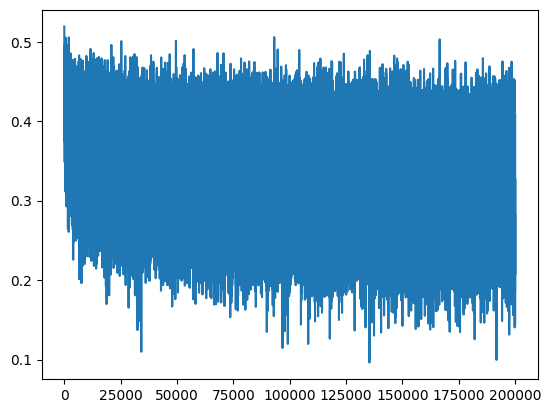

In [ ]:
plt.plot(stepi, lossi)

In [ ]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
hidd = torch.tanh(h @ W2 + b2)
logits = hidd @ W3 + b3
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1029, grad_fn=<NllLossBackward0>)

In [ ]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
hidd = torch.tanh(h @ W2 + b2)
logits = hidd @ W3 + b3
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1702, grad_fn=<NllLossBackward0>)

**Part 4**

In [26]:
class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)*0 #/fan_in**0.5 # fan_in might not be needed when batch_normalised
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)

layers = [
    Linear(n_embd*block_size, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
]

# with torch.no_grad():
#     layers[-1].weight*=0.1
#     for layer in layers[:-1]:
#         if isinstance(layer,Linear):
#             layer.weight*=5/3 # for tanh this value exactly stabilises the activation if it less than this it will be zero faster otherwise it will be close to 1.
            # can be kept one when batch_normalised

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497


In [27]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    #mini-batch construction
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    # if i>=1000:
    #   break

      0/ 200000: 3.2958
  10000/ 200000: 3.0031
  20000/ 200000: 2.7542
  30000/ 200000: 2.5913
  40000/ 200000: 2.7889
  50000/ 200000: 2.7550
  60000/ 200000: 2.7644
  70000/ 200000: 2.8402
  80000/ 200000: 2.9719
  90000/ 200000: 2.9844
 100000/ 200000: 2.8361
 110000/ 200000: 2.8719
 120000/ 200000: 2.8882
 130000/ 200000: 2.5855
 140000/ 200000: 2.5459
 150000/ 200000: 2.6360
 160000/ 200000: 3.0687
 170000/ 200000: 2.7420
 180000/ 200000: 2.9107
 190000/ 200000: 2.6757


layer 1 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 3 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 5 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 7 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%
layer 9 (      Tanh): mean +0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'activation distribution')

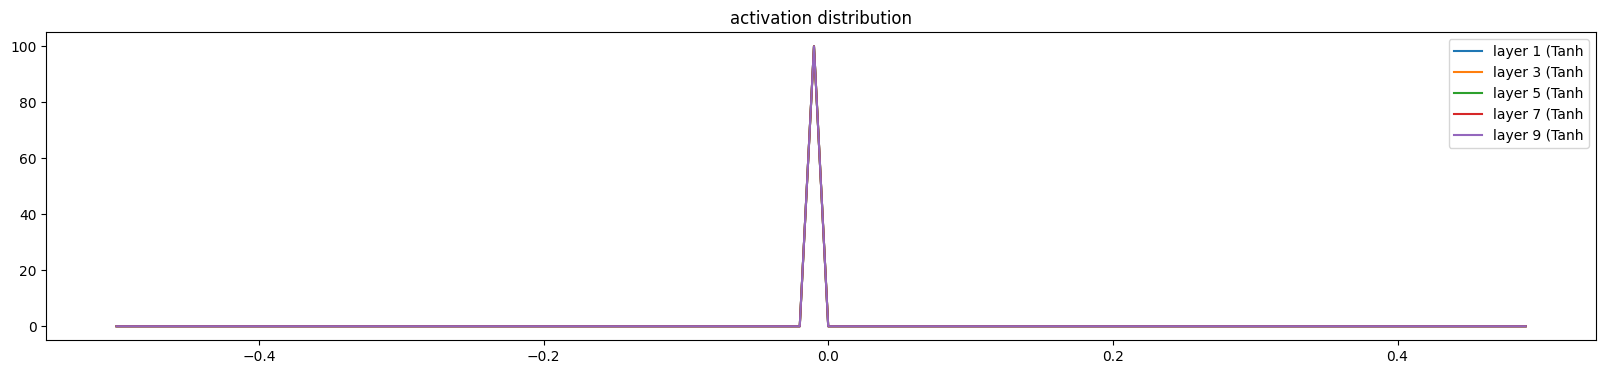

In [28]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 1 (      Tanh): mean +0.000000, std 0.000000e+00
layer 3 (      Tanh): mean +0.000000, std 0.000000e+00
layer 5 (      Tanh): mean +0.000000, std 0.000000e+00
layer 7 (      Tanh): mean +0.000000, std 0.000000e+00
layer 9 (      Tanh): mean +0.000000, std 0.000000e+00


Text(0.5, 1.0, 'gradient distribution')

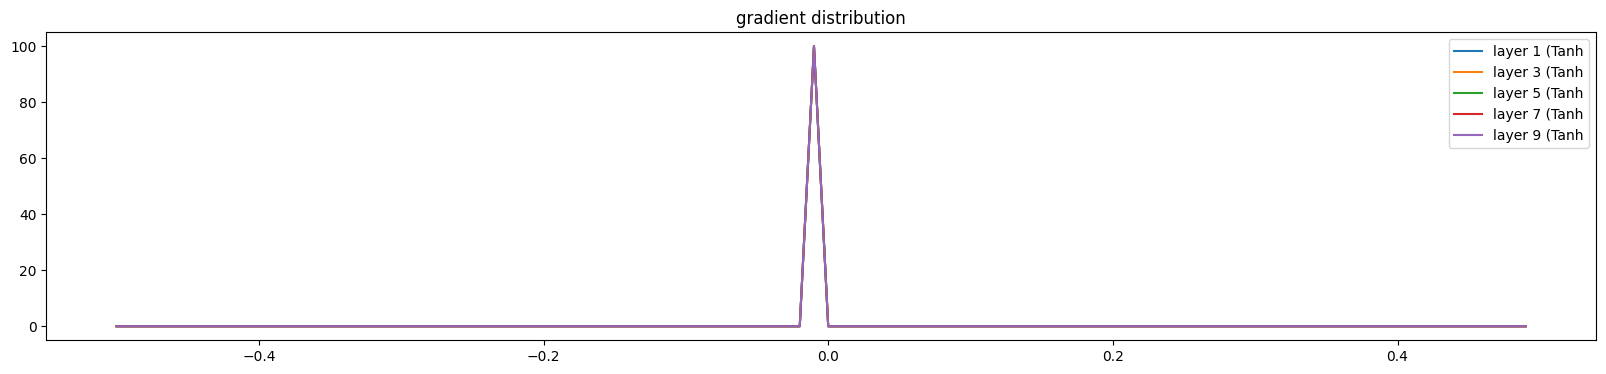

In [29]:
plt.figure(figsize=(20, 4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 0.000000e+00 | grad:data ratio 0.000000e+00
weight  (30, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight (100, 100) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan
weight  (100, 27) | mean +0.000000 | std 0.000000e+00 | grad:data ratio nan


Text(0.5, 1.0, 'weights gradient distribution')

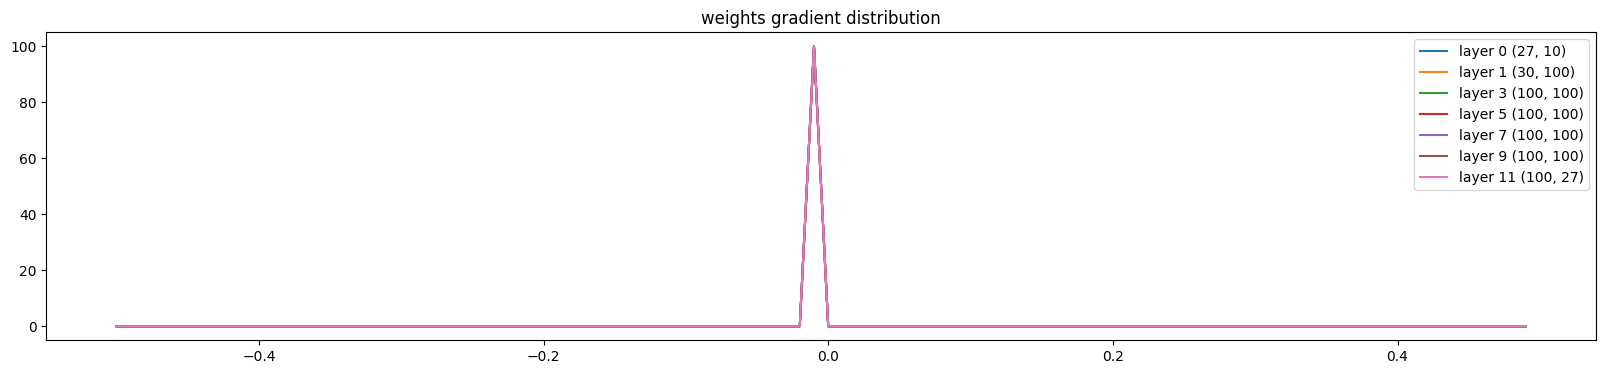

In [30]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

In [31]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.9747812747955322
val 2.9747812747955322


Observe that the losses are not as good as before which says that the model is not properly trained.

When all the weights and biases are initialised to 0, all the activations and gradients are shrinking towards zero. All weights get updated uniformly indicating the symmetry problem.

**Part 5**

In [ ]:
# Concept of folding into
# In the series of lines of code used to fing the loss after training,
# hpreact = embcat @ W1 + b1
# hpreact =(bngain)(hpreact - bnmean_running)/bnstd_running + bnbias
# we are indirectly doing
# W1 = (bngain)(W1)/bnstd_running and b1 = bngain(b1-bnmean_running)/bnstd_running + bnbias
# This is called folding the batch_norm layer into the weights and erasing the batch_norm layer after training

In [1]:
# Now we shall do that for a 3-layer MLP

In [21]:
n_embd = 10 # dimension of each character
n_hidden_1 = 200 # number of nodes in hidden layer
n_hidden_2 = 100

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g)
W1 = torch.randn((n_embd*block_size, n_hidden_1), generator=g)*(5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn(n_hidden_1, generator=g)*0.01
W2 = torch.randn((n_hidden_1, n_hidden_2), generator=g)*0.01
b2 = torch.randn(n_hidden_2, generator=g)*0.01
W3 = torch.randn((n_hidden_2, vocab_size), generator=g)*0.01
b3 = torch.randn(vocab_size, generator=g)*0

bngain1 = torch.ones((1, n_hidden_1))
bnbias1 = torch.zeros((1, n_hidden_1))
bnmean_running1 = torch.zeros((1, n_hidden_1))
bnstd_running1 = torch.ones((1, n_hidden_1))

bngain2 = torch.ones((1, n_hidden_2))
bnbias2 = torch.zeros((1, n_hidden_2))
bnmean_running2 = torch.zeros((1, n_hidden_2))
bnstd_running2 = torch.ones((1, n_hidden_2))

parameters = [C, W1, b1, W2, b2, W3, b3, bngain1, bnbias1, bngain2, bnbias2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

29897


In [22]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

    # mini-batch construction
    indx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[indx], Ytr[indx]

    # forward pass
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact1 = embcat @ W1 + b1 # if too small tanh does nothing, if too large then tanh is saturated we want it to be roughly guassian
    bnmeani1 = hpreact1.mean(0, keepdim=True)
    bnstdi1 = hpreact1.std(0, keepdim=True)
    hpreact1 = bngain1*(hpreact1 - bnmeani1)/bnstdi1 + bnbias1

    with torch.no_grad():
        bnmean_running1 = 0.999*bnmean_running1 + 0.001*bnmeani1
        bnstd_running1 = 0.999*bnstd_running1 + 0.001*bnstdi1

    h1 = torch.tanh(hpreact1)
    hpreact2 = h1 @ W2 + b2 # if too small tanh does nothing, if too large then tanh is saturated we want it to be roughly guassian
    bnmeani2 = hpreact2.mean(0, keepdim=True)
    bnstdi2 = hpreact2.std(0, keepdim=True)
    hpreact2 = bngain2*(hpreact2 - bnmeani2)/bnstdi2 + bnbias2

    with torch.no_grad():
        bnmean_running2 = 0.999*bnmean_running2 + 0.001*bnmeani2
        bnstd_running2 = 0.999*bnstd_running2 + 0.001*bnstdi2

    h2 = torch.tanh(hpreact2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
      # print("data:", p.data, "grad:", p.grad)
      p.data += -lr * p.grad

    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')

    lossi.append(loss.log10().item())
#     break

      0/ 200000: 3.3218
  10000/ 200000: 1.8671
  20000/ 200000: 2.2726
  30000/ 200000: 2.1054
  40000/ 200000: 2.0655
  50000/ 200000: 2.3741
  60000/ 200000: 2.1735
  70000/ 200000: 2.0647
  80000/ 200000: 2.4912
  90000/ 200000: 1.9973
 100000/ 200000: 2.1728
 110000/ 200000: 2.4736
 120000/ 200000: 1.9946
 130000/ 200000: 2.5599
 140000/ 200000: 2.1301
 150000/ 200000: 1.7473
 160000/ 200000: 2.2115
 170000/ 200000: 1.8176
 180000/ 200000: 1.9804
 190000/ 200000: 2.0976


In [23]:
folded_W1 = bngain1*W1/bnstd_running1
folded_b1 = bngain1*(b1-bnmean_running1)/bnstd_running1 + bnbias1
folded_W2 = bngain2*W2/bnstd_running2
folded_b2 = bngain2*(b2-bnmean_running2)/bnstd_running2 + bnbias2

In [24]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact1 = embcat @ folded_W1 + folded_b1
    h1 = torch.tanh(hpreact1)
    hpreact2 = h1 @ folded_W2 + folded_b2
    h2 = torch.tanh(hpreact2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0280232429504395
val 2.0911452770233154


In [25]:
# Let's check if this gives the same as when batch_norm layer is not erased
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact1 = embcat @ W1 + b1
    hpreact1 = bngain1 * (hpreact1 - bnmean_running1) / bnstd_running1 + bnbias1
    h1 = torch.tanh(hpreact1)
    hpreact2 = h1 @ W2 + b2
    hpreact2 = bngain2 * (hpreact2 - bnmean_running2) / bnstd_running2 + bnbias2
    h2 = torch.tanh(hpreact2)
    logits = h2 @ W3 + b3
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0280232429504395
val 2.0911452770233154


In [ ]:
# Hurray we did it..